In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
import json
import os 
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.preprocessing import StandardScaler
import joblib  # 用於保存模型

from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
label_to_coordinates = {
    "1-1": (0, 0), "1-2": (0.6, 0), "1-3": (1.2, 0), "1-4": (1.8, 0), "1-5": (2.4, 0), "1-6": (3.0, 0),"1-7": (3.6, 0), "1-8": (4.2, 0), "1-9": (4.8, 0), "1-10": (5.4, 0), "1-11": (6.0, 0),
    "2-1": (0, 0.6), "2-11": (6.0, 0.6),
    "3-1": (0, 1.2), "3-11": (6.0, 1.2),
    "4-1": (0, 1.8), "4-11": (6.0, 1.8),
    "5-1": (0, 2.4), "5-11": (6.0, 2.4),
    "6-1": (0, 3.0), "6-2": (0.6, 3.0), "6-3": (1.2, 3.0), "6-4": (1.8, 3.0), "6-5": (2.4, 3.0),"6-6": (3.0, 3.0), "6-7": (3.6, 3.0), "6-8": (4.2, 3.0), "6-9": (4.8, 3.0), "6-10": (5.4, 3.0), "6-11": (6.0, 3.0),
    "7-1": (0, 3.6), "7-11": (6.0, 3.6),
    "8-1": (0, 4.2), "8-11": (6.0, 4.2),
    "9-1": (0, 4.8), "9-11": (6.0, 4.8),
    "10-1": (0, 5.4), "10-11": (6.0, 5.4),
    "11-1": (0, 6.0), "11-2": (0.6, 6.0), "11-3": (1.2, 6.0), "11-4": (1.8, 6.0), "11-5": (2.4, 6.0),"11-6": (3.0, 6.0), "11-7": (3.6, 6.0), "11-8": (4.2, 6.0), "11-9": (4.8, 6.0), "11-10": (5.4, 6.0), "11-11": (6.0, 6.0)
}
label_mapping = {
    '11': '1-1','10': '1-2','9': '1-3','8': '1-4','7': '1-5','6': '1-6','5': '1-7','4': '1-8','3': '1-9','2': '1-10','1': '1-11',
    '12': '2-1','30': '2-11',
    '13': '3-1','29': '3-11',
    '14': '4-1','28': '4-11',
    '15': '5-1','27': '5-11',
    '16': '6-1','17': '6-2','18': '6-3','19': '6-4','20': '6-5','21': '6-6','22': '6-7','23': '6-8','24': '6-9','25': '6-10','26': '6-11',
    '49': '7-1','31': '7-11',
    '48': '8-1','32': '8-11',
    '47': '9-1','33': '9-11',
    '46': '10-1','34': '10-11',
    '45': '11-1','44': '11-2','43': '11-3','42': '11-4','41': '11-5','40': '11-6','39': '11-7','38': '11-8','37': '11-9','36': '11-10','35': '11-11'
}

In [3]:
selected_columns = ['Label',
                                'AP1_Rssi','AP2_Rssi','AP3_Rssi','AP4_Rssi'
                                ]  

what_data = "test"
# what_data = "DNN_3Layer_1AP_Best_combine_F_S_R_20241214_usingearlystopepchoc10000"

# 'AP1_Distance (mm)',
# 'AP1_StdDev (mm)',

In [4]:
# 1. 讀取資料
file_path = "timestamp_allignment_Balanced_2024_12_14_rtt_logs.csv"

date = "2024_12_14"

data = pd.read_csv(file_path, usecols=selected_columns)

print(data.head())

target_column = 'Label'  # 替換成目標欄位名稱
label_column = 'Label'  # 替換成目標欄位名稱

  Label  AP1_Rssi  AP2_Rssi  AP3_Rssi  AP4_Rssi
0  1-11     -60.0     -68.0     -59.0     -61.0
1  1-11     -62.0     -70.0     -59.0     -59.0
2  1-11     -61.0     -69.0     -55.0     -62.0
3  1-11     -62.0     -69.0     -55.0     -63.0
4  1-11     -61.0     -70.0     -55.0     -62.0


In [5]:
# 資料前處理 (一): 刪除前後n筆資料
n = 1
# 確保依據Label排序
data = data.sort_values(by=label_column).reset_index(drop=True)

# 建立一個空的 DataFrame 用於存放處理後的資料
processed_data = pd.DataFrame(columns=data.columns)


# # 針對每個Label群組進行處理
# for label, group in data.groupby(label_column):
#     group = group.iloc[n:-n]
#     # 將處理後的群組資料加入
#     processed_data = pd.concat([processed_data, group], ignore_index=True)

processed_data = data
processed_data


,Label,AP1_Rssi,AP2_Rssi,AP3_Rssi,AP4_Rssi
0,1-1,-62.0,-73.0,-48.0,-65.0
1,1-1,-51.0,-73.0,-55.0,-67.0
2,1-1,-63.0,-73.0,-56.0,-67.0
3,1-1,-53.0,-73.0,-55.0,-67.0
4,1-1,-58.0,-73.0,-56.0,-67.0
...,...,...,...,...,...
19644,9-11,-57.0,-69.0,-65.0,-51.0
19645,9-11,-58.0,-70.0,-65.0,-52.0
19646,9-11,-57.0,-69.0,-64.0,-51.0
19647,9-11,-57.0,-69.0,-66.0,-52.0


In [6]:
data_imputed = processed_data.groupby(label_column).apply(
    lambda group: group.fillna(group.mean())
).reset_index()
data_imputed

print("Number of data per RP : " + str(len(data_imputed)/49))

Number of data per RP : 401.0


In [7]:
# 建立 Label 映射
y = data_imputed[target_column]
# label_mapping = {str(i): label for i, label in enumerate(y.unique())}
reverse_label_mapping = {v: int(k) - 1 for k, v in label_mapping.items()}  # 讓數字標籤 -1
y_numeric = y.map(reverse_label_mapping)

print("Final reverse_label_mapping in DNN:", reverse_label_mapping)
print("y_numeric unique values in DNN:", y_numeric.unique())

Final reverse_label_mapping in DNN: {'1-1': 10, '1-2': 9, '1-3': 8, '1-4': 7, '1-5': 6, '1-6': 5, '1-7': 4, '1-8': 3, '1-9': 2, '1-10': 1, '1-11': 0, '2-1': 11, '2-11': 29, '3-1': 12, '3-11': 28, '4-1': 13, '4-11': 27, '5-1': 14, '5-11': 26, '6-1': 15, '6-2': 16, '6-3': 17, '6-4': 18, '6-5': 19, '6-6': 20, '6-7': 21, '6-8': 22, '6-9': 23, '6-10': 24, '6-11': 25, '7-1': 48, '7-11': 30, '8-1': 47, '8-11': 31, '9-1': 46, '9-11': 32, '10-1': 45, '10-11': 33, '11-1': 44, '11-2': 43, '11-3': 42, '11-4': 41, '11-5': 40, '11-6': 39, '11-7': 38, '11-8': 37, '11-9': 36, '11-10': 35, '11-11': 34}
y_numeric unique values in DNN: [10  1  0  9  8  7  6  5  4  3  2 45 33 44 35 34 43 42 41 40 39 38 37 36
 11 29 12 28 13 27 14 26 15 24 25 16 17 18 19 20 21 22 23 48 30 47 31 46
 32]


In [8]:
# 把label部分拿掉
X = data_imputed.drop(columns=['level_1','Label'])
print(X.head())

   AP1_Rssi  AP2_Rssi  AP3_Rssi  AP4_Rssi
0     -62.0     -73.0     -48.0     -65.0
1     -51.0     -73.0     -55.0     -67.0
2     -63.0     -73.0     -56.0     -67.0
3     -53.0     -73.0     -55.0     -67.0
4     -58.0     -73.0     -56.0     -67.0


In [9]:
scaler = StandardScaler()
columns_to_scale = selected_columns.copy()  # 建立副本，避免影響原始變數
columns_to_scale.remove('Label')  # 在副本上移除 'Label'
X_scaled = scaler.fit_transform(X[columns_to_scale])

# 保存標準化器
joblib.dump(scaler, f'scaler_{what_data}.pkl')

print(X_scaled)

[[-0.33534256 -1.06008268  1.50052306 -1.29455783]
 [ 2.00872971 -1.06008268  0.4157486  -1.67424054]
 [-0.54844003 -1.06008268  0.26078082 -1.67424054]
 ...
 [ 0.73014484 -0.32852003 -0.97896143  1.36322117]
 [ 0.73014484 -0.32852003 -1.28889699  1.17337981]
 [ 2.43492466 -0.32852003 -1.28889699  1.17337981]]


In [10]:
from sklearn.model_selection import StratifiedShuffleSplit

In [11]:
ap = 'test'
root = 'test'

dataamount = 320
N_val = 20

N_train = dataamount # 訓練集每個類別至少要有 N_train 筆資料
test_val_ratio = 1  # 剩餘資料中，50% 作為驗證集，50% 作為測試集

In [12]:
# 轉為 DataFrame 方便操作
data = pd.DataFrame(X_scaled)
data['label'] = y_numeric  # 加入 label 欄位

train_data_full = data.groupby('label', group_keys=False).sample(n=N_train, replace=False) # ,random_state=42

train_data_full


,0,1,2,3,label
998,0.090852,-0.328520,-0.204123,-0.535192,0
1133,-0.122245,-0.511411,-0.514058,-0.535192,0
1085,-0.335343,-0.328520,-0.204123,-0.725034,0
1097,-0.335343,-0.328520,-0.049155,-0.725034,0
838,-0.122245,-0.511411,-0.359090,-1.104716,0
...,...,...,...,...,...
17317,-0.974635,0.403043,-0.359090,-0.345351,48
17261,-1.187732,0.403043,-0.359090,-0.535192,48
17572,-1.187732,0.585933,-0.204123,-0.535192,48
17457,-1.187732,0.585933,-0.359090,-0.535192,48


In [13]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=N_val / N_train,random_state=42) 
train_index, val_index = next(sss.split(train_data_full.drop(columns=['label']), train_data_full['label']))
train_data = train_data_full.iloc[train_index]
val_data = train_data_full.iloc[val_index]

remaining_data = data.drop(train_data_full.index)

In [14]:
X_train, y_train = train_data.drop(columns=['label']).values, train_data['label'].values
X_val, y_val = val_data.drop(columns=['label']).values, val_data['label'].values
X_test, y_test = remaining_data.drop(columns=['label']).values, remaining_data['label'].values

# **計算每個 Set 內各 Label 的資料數量**
train_label_counts = pd.Series(y_train).value_counts().sort_index()
val_label_counts = pd.Series(y_val).value_counts().sort_index()
test_label_counts = pd.Series(y_test).value_counts().sort_index()

# **確保所有 Labels 都有出現在三個 Set 裡**
all_labels = sorted(set(train_label_counts.index) | set(val_label_counts.index) | set(test_label_counts.index))
label_distribution = pd.DataFrame(index=all_labels)

label_distribution["Training Set"] = train_label_counts
label_distribution["Validation Set"] = val_label_counts
label_distribution["Test Set"] = test_label_counts

# **用 0 填補缺失值（表示該 Label 在該 Set 中沒有數據）**
label_distribution = label_distribution.fillna(0).astype(int)

from IPython.display import display
display(label_distribution)

,Training Set,Validation Set,Test Set
0,300,20,81
1,300,20,81
2,300,20,81
3,300,20,81
4,300,20,81
5,300,20,81
6,300,20,81
7,300,20,81
8,300,20,81
9,300,20,81


In [15]:
import time
# 記錄開始時間
start_time = time.time()

In [16]:
# X_train, y_train 
# X_val, y_val
# X_test, y_test 

In [17]:
# 建立 DNN 模型 (包含 BatchNormalization 與 Dropout)
model = keras.Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(len(label_mapping), activation='softmax')
])

# 可顯式設定學習率
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 設定 EarlyStopping 以在驗證集不再改善時提前停止
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# 如有需要也可以加入 ModelCheckpoint 保存最佳模型權重：
# checkpoint = ModelCheckpoint('best_dnn_model.h5', monitor='val_loss', save_best_only=True)

# 訓練模型 (設置較大 epoch 數並依 EarlyStopping 停止)
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=10000,
                    batch_size=32,
                    verbose=1,
                    callbacks=[early_stop])

Epoch 1/10000
460/460 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4072 - loss: 2.2033 - val_accuracy: 0.7939 - val_loss: 0.7113
Epoch 2/10000
460/460 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6916 - loss: 0.9561 - val_accuracy: 0.8102 - val_loss: 0.5484
Epoch 3/10000
460/460 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7293 - loss: 0.8213 - val_accuracy: 0.8531 - val_loss: 0.4948
Epoch 4/10000
460/460 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7621 - loss: 0.7249 - val_accuracy: 0.8480 - val_loss: 0.4554
Epoch 5/10000
460/460 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7756 - loss: 0.6859 - val_accuracy: 0.8653 - val_loss: 0.4261
Epoch 6/10000
460/460 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7873 - loss: 0.6616 - val_accuracy: 0.8643 - val_loss: 0.4273
Epoch 7/10000
460/460 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7872 - loss: 0.6418 - val_accuracy: 0.8612 - val_loss: 0.4253
Epoch 8/10000
460/460 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7969 - loss: 0

In [18]:
# 記錄結束時間
end_time = time.time()


# Needsave
# 計算訓練時間（秒）
training_time = end_time - start_time
print(f"訓練時間：{training_time:.2f} 秒")

訓練時間：73.07 秒


In [19]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f} - Test Accuracy: {test_accuracy:.4f}")

# 預測結果
y_test_pred = np.argmax(model.predict(X_test), axis=1)
print("Classification Report:")
print(classification_report(y_test, y_test_pred))

# # 若需要混淆矩陣
# cm = confusion_matrix(y_test, y_test_pred)
# plt.figure(figsize=(10, 8))
# sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
# plt.xlabel("Predicted")
# plt.ylabel("True")
# plt.title("Confusion Matrix")
# plt.show()

# 若需要儲存模型，可使用：
model.save('optimized_dnn_model.h5')

Test Loss: 0.2621 - Test Accuracy: 0.9106
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.90      0.92        81
           1       0.75      0.84      0.79        81
           2       0.94      1.00      0.97        81
           3       0.91      0.98      0.94        81
           4       0.87      0.81      0.84        81
           5       0.98      0.98      0.98        81
           6       0.92      0.84      0.88        81
           7       0.92      0.81      0.86        81
           8       1.00      0.99      0.99        81
           9       0.99      0.98      0.98        81
          10       0.95      0.96      0.96        81
          11       0.97      0.95      0.96        81
          12       0.90      1.00      0.95        81
          13       0.60      0.38      0.47        81
          14       0.89      0.84      0.87        81
          15       0.86      0.91      0.89        81
          16       0.84      0.94      0.89        81
    

In [20]:
mde_report_per_fold = {}

# 進行預測
y_test_pred_numeric = model.predict(X_test)
y_pred_classes = np.argmax(y_test_pred_numeric, axis=1)
y_test_pred_labels = [label_mapping[str(num + 1)] for num in y_pred_classes]  # 補回 +1


# 計算 MDE
y_test_pred_coordinates = np.array([label_to_coordinates[label] for label in y_test_pred_labels])
y_test_coordinates = np.array([label_to_coordinates[label_mapping[str(label + 1)]] for label in y_test])


distances = np.linalg.norm(y_test_pred_coordinates - y_test_coordinates, axis=1)
avg_mde = np.mean(distances)
print(f"MDE: {avg_mde:.4f}")

# 記錄每個 RP 在當前 fold 的 MDE
for true_label, distance in zip(y_test, distances):
    if true_label not in mde_report_per_fold:
        mde_report_per_fold[true_label] = []
    mde_report_per_fold[true_label].append(distance)  # 存所有 fold 的 MDE

# 計算 5-Fold 平均 MDE
# mde_report_avg = {label: {"mde": np.mean(distances), "count": len(distances)} for label, distances in mde_report_per_fold.items()}

mde_report_avg = {int(label): {"mde": np.mean(distances), "count": len(distances)} 
                   for label, distances in mde_report_per_fold.items()}

# 儲存到 JSON 檔案
file_path = "Testing_mde"
with open(file_path, "w") as f:
    json.dump(mde_report_avg, f, indent=4)

print(f"MDE report saved to: {file_path}")


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step
MDE: 0.2347
MDE report saved to: Testing_mde


In [21]:
print(f"MDE: {avg_mde:.4f}")
print(f"Accuracy: {test_accuracy:.4f}")

MDE: 0.2347
Accuracy: 0.9106


In [22]:
columns_to_scalettt = list(X.columns)

print(columns_to_scalettt)


['AP1_Rssi', 'AP2_Rssi', 'AP3_Rssi', 'AP4_Rssi']


c:\Users\吳定洋\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\吳定洋\AppData\Local\Programs\Python\Python312\Lib\site-packages\shap\explainers\_deep\deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
c:\Users\吳定洋\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(980, 4))']
  warnings.warn(msg)
c:\Users\吳定洋\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs

shap_array.shape = (4, 49)
Average SHAP values per feature: [0.00965083 0.01197127 0.0070926  0.01112315]


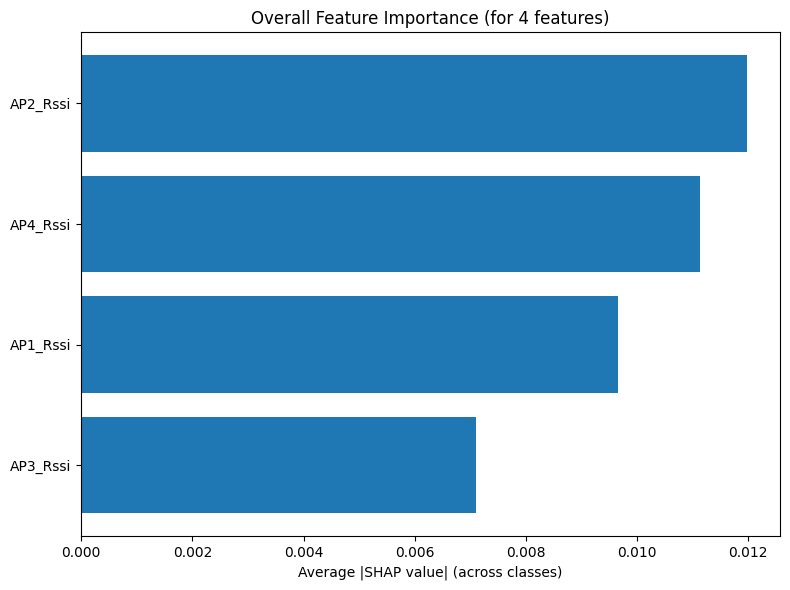

In [ ]:
# ------------------ Feature Importance 分析 (使用 SHAP) ------------------
import shap

# 確認你的 feature 名稱（4 個）
columns_to_scale = ['AP1_Rssi', 'AP2_Rssi', 'AP3_Rssi', 'AP4_Rssi']

# Step 1: 選擇一批驗證資料
# 這裡以 X_val 前 100 筆作為例子
X_sample = X_test # 預期 X_sample.shape 為 (100, 4)

# Step 2: 建立 SHAP explainer
explainer = shap.DeepExplainer(model, X_sample)

# Step 3: 取得 SHAP 值
# 對於多分類 softmax 模型，DeepExplainer 通常會傳回一個 list，
# 而你取 shap_values[0] 可能得到的 shape 為 (4, 49)，也就是 (n_features, n_classes)
shap_values = explainer.shap_values(X_sample)
shap_array = np.array(shap_values[0])
print("shap_array.shape =", shap_array.shape)

# Step 4: 判斷 SHAP 輸出維度，自動適配
if shap_array.ndim == 3:
    # 若 shape 為 (samples, n_features, n_classes)
    avg_shap = np.mean(np.abs(shap_array), axis=(0, 2))
elif shap_array.ndim == 2:
    # 在你目前的情形，shap_array.shape 為 (n_features, n_classes)
    # 輸入為 4 個 feature 與 49 個類別
    # 所以對 axis=1 平均，得到 shape 為 (n_features,)
    avg_shap = np.mean(np.abs(shap_array), axis=1)
else:
    raise ValueError(f"Unsupported SHAP array shape: {shap_array.shape}")

print("Average SHAP values per feature:", avg_shap)

# Step 5: 對 feature importance 進行排序
if len(avg_shap) != len(columns_to_scale):
    raise ValueError(f"Feature 數量不一致：avg_shap 有 {len(avg_shap)}，但 columns_to_scale 是 {len(columns_to_scale)}")
sorted_indices = np.argsort(avg_shap)[::-1]
sorted_features = [columns_to_scale[i] for i in sorted_indices]
sorted_avg_shap = avg_shap[sorted_indices]

# Step 6: 繪製橫向長條圖
plt.figure(figsize=(8, 6))
plt.barh(sorted_features, sorted_avg_shap)
plt.gca().invert_yaxis()  # 讓最重要的 feature 放在上面
plt.xlabel("Average |SHAP value| (across classes)")
plt.title("Overall Feature Importance (for 4 features)")
plt.tight_layout()
plt.show()


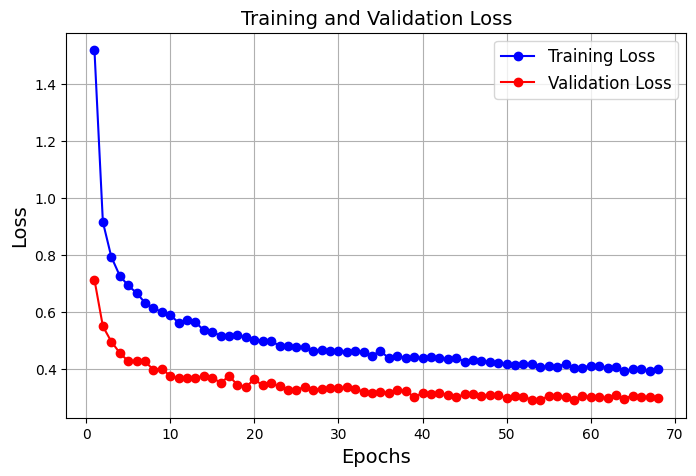

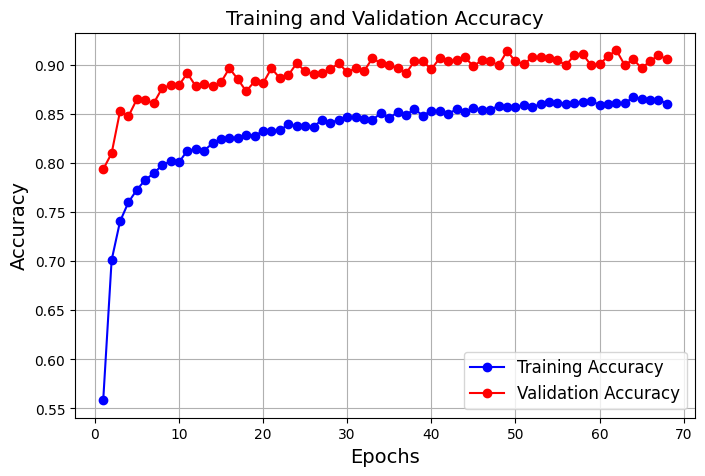

In [24]:
# 假設 history 是 model.fit(...) 返回的歷史記錄
def plot_learning_curves(history):
    epochs = range(1, len(history.history['loss']) + 1)
    
    # 繪製 Loss 曲線
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, history.history['loss'], 'bo-', label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss', fontsize=14)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()

    # 繪製 Accuracy 曲線 (若有準確率指標)
    if 'accuracy' in history.history:
        plt.figure(figsize=(8, 5))
        plt.plot(epochs, history.history['accuracy'], 'bo-', label='Training Accuracy')
        plt.plot(epochs, history.history['val_accuracy'], 'ro-', label='Validation Accuracy')
        plt.title('Training and Validation Accuracy', fontsize=14)
        plt.xlabel('Epochs', fontsize=14)
        plt.ylabel('Accuracy', fontsize=14)
        plt.legend(fontsize=12)
        plt.grid(True)
        plt.show()

# 在訓練結束後呼叫該函數:
plot_learning_curves(history)